In [264]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import warnings 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import tweepy
import json
import re
# from config import Config as cfg

In [265]:
# NLP library
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Impact of Social Media on Social Movements through Data & Sentiment analysis

Urvi Guglani, DIGHUM 101, July 1, 2020

![alt text](readMe_img.png "Img")


### Introduction
What happened with George Floyd has definitely changed the course of history. 

Given the powerful use of social media in the past few weeks, I wanted to explore the Impact of Social Media on Social Movements through Data & Sentiment analysis. 

Through my project, I will be looking at analyzing racist & sexist remarks on twitter and how social media movements has influenced this sentiment.

### Research Question
- How does racism/sexism influence the sentiment of tweets? 
- What words influence positive or negative tweets?
- What role does this play in perpetuating racism?

### Data

- `all_tweets`: Tweepy Twitter API extracted tweets, split into train & test
- `train_original`: Train dataset
- `test_original`: Test dataset
Using Tweepy (obtained from Online sources)

Supplementary Datasets (From Census Dataset downloaded from Kaggle)
- `police_killings_dataset`: Census-based Police Brutalities CSV file 
- `state_literacy_dataset`: Census-based Percent Over 25 Completed High School State-Wise
- `median_house_income_dataset`: Census based median household income
- `poverty_line_dataset`: Census based percentage of people below poverty line
    

In [222]:
"""
Method to get all the datasets required for this project.
If you want to change the datasets, simply modify the parts read.
"""
def getDatasets():
    train_original = pd.read_csv('./datasets/train.csv')
    test_original = pd.read_csv('./datasets/test.csv')
    all_tweets = pd.read_csv('./datasets/tweets.csv')
    police_killings_dataset = pd.read_csv('./datasets/PoliceKillingsUS.csv')
    state_literacy_dataset = pd.read_csv('./datasets/PercentOver25CompletedHighSchool.csv')
    median_house_income_dataset = pd.read_csv('./datasets/MedianHouseholdIncome2015.csv')
    poverty_line_dataset = pd.read_csv('./datasets/PercentagePeopleBelowPovertyLevel.csv')
    return test_original, train_original,all_tweets,police_killings_dataset,state_literacy_dataset,median_house_income_dataset,poverty_line_dataset

test_original, train_original, combine, police_killings_dataset,state_literacy_dataset,median_house_income_dataset,poverty_line_dataset  = getDatasets()

#### Methods
Using the combined dataset: 
- id : id based on dataset
- label : 
    - ‘1’ denotes the tweet as racist/sexist and label 
    - ‘0’ denotes the tweet is not racist/sexist,our objective is to predict the labels on the given test dataset.

In [223]:
def remove_pattern(text,pattern):
    for i in re.findall(pattern,text):
        text = re.sub(i,"",text)
    return text 

# Check the method is working
np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

array(['  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "  thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
       '  bihday your majesty', ...,
       '#hillary #campaigned today in #ohio((omg)) &amp; used words like "assets&amp;liability" never once did #clinton say thee(word) #radicalization   ',
       'happy, at work conference: right mindset leads to culture-of-development organizations    #work #mindset',
       'my   song "so glad" free download!  #shoegaze #newmusic #newsong'],
      dtype='|S559')

In [224]:
def remove_punctuation():
    r1,r2, emp = "@[\w]*", r'''[^\w\d\s]''', " "
    
    combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], r1)
    #Make lower case because we don't want two words that are the same represented as two diff words
    combine["Tidy_Tweets"] = combine["Tidy_Tweets"].str.lower()
    # get rid of punctuation since it will cause us to fail to match words
    combine['Tidy_Tweets'] =  combine['Tidy_Tweets'].str.replace(r2, emp)
    return
remove_punctuation()
combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation


In [225]:
def split_sentences_into_words():
    tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    combine['Tidy_Tweets'] = tokenized_tweet
#     combin
split_sentences_into_words()
combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation


In [226]:
stop_words = set(stopwords.words('english')) 
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
# df['response'] = df['response']
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([item for item in x.split() if item != 'amp']))

combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,bihday majesty
3,4,0.0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0.0,factsguide: society now #motivation,factsguide society motivation


#### Data Visualizations

In [227]:
def pos_or_neg(num, img_url):
    all_words = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==num])
    shape_chosen = 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png'
    image_colors = ImageColorGenerator(np.array(Image.open(requests.get(shape_chosen, stream=True).raw)))
    url_given = 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png'
    wc = WordCloud(background_color='black', height=2000, width=5000,mask=np.array(Image.open(requests.get(url_given, stream=True).raw))).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()
    

- First we look at the most popular "positive words". 
- These words are the LEAST sexist and LEAST racist from all the tweets in our dataset
- This isn't too surprising - since it's quite common knowledge that love, smile and happy are positive words. 

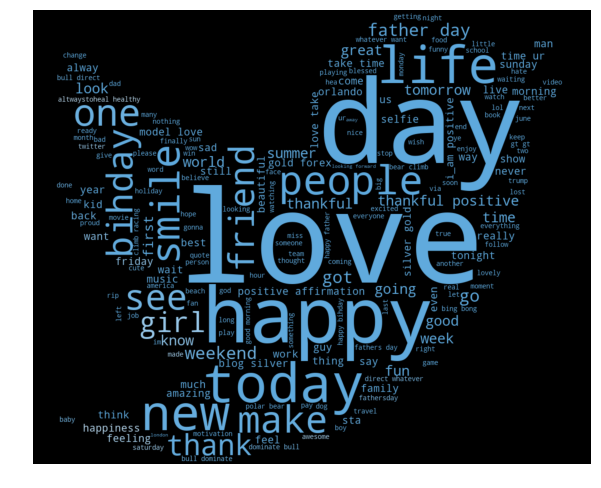

In [228]:
## 1 is negative, 0 is positive 
pos_or_neg(0, 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png')

 - negative words were more surprising because they showed how politically driven twitter is
 - it was quite sad to see religion, gender, race being associated negatively and not positively

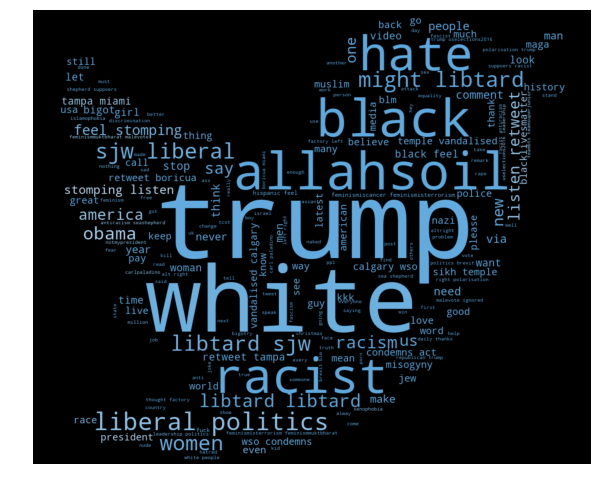

In [229]:
pos_or_neg(1, 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png')

In [231]:
# most positive tweets
combine['Tidy_Tweets'][combine['label']==0]

0        father dysfunctional selfish drags kids dysfun...
1        thanks lyft credit use cause offer wheelchair ...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
5        2 2 huge fan fare big talking leave chaos pay ...
6                                   camping tomorrow danny
7        next school year year exams think school exams...
8        love land allin cavs champions cleveland cleve...
9                                              welcome gr8
10       ireland consumer price index mom climbed previ...
11       selfish orlando standwithorlando pulseshooting...
12                   get see daddy today 80days gettingfed
15               ouch junior angry got7 junior yugyoem omg
16                        thankful paner thankful positive
18       friday smiles around via ig user cookies make ...
19                      know essential oils made chemica

In [232]:
# most positive tweets
combine['Tidy_Tweets'][combine['label']==1]

13       cnn calls michigan middle school build wall ch...
14       comment australia opkillingbay seashepherd hel...
17                                           retweet agree
23                                  lumpy says prove lumpy
34       unbelievable 21st century need something like ...
56                                   lets fight love peace
68       white establishment blk folx running around lo...
77       hey white people call people white race identi...
82        altright uses insecurity lure men whitesupremacy
111      interested linguistics address race racism pow...
114                              mocked obama black brexit
131       people protesting trump republican trump fuhered
151      yes call michelleobama gorilla racists long th...
156      smaller hands show barry probably lied knicks ...
167      point one finger millions pointed right back j...
192             might libtard libtard sjw liberal politics
210          take trash america voted hate voted voted v

In [260]:
def pos_neg_bar(num, title):
    word_list = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==num])
    word_list = word_list.split()
    word_list = all_words
    counts = Counter(word_list)
    labels, values = zip(*counts.items())
    indSort = np.argsort(values)[::-1][:10]
    indSort
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]
    indexes = np.arange(len(labels))
    bar_width = 0.35
    
    plt.bar(indexes, values)
    plt.xticks(rotation=90)
    # add labels
    plt.title(title)
    plt.xticks(indexes + bar_width, labels)
    plt.ylabel("frequency")
    plt.xlabel("word")
    plt.show()

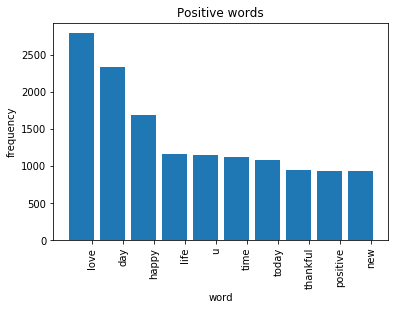

In [261]:
pos_neg_bar(0, "Positive words")

#### Applying Machine Learning

- Purpose: learning how apply Machine Learning models using these features to predict whether a tweet falls into the Positive: ‘0’ or Negative: ‘1’ sentiment...
- Also would help make my analysis above more robust
- Supervised learning is where you have input variables (x) and an output variable (Y) and you use an algorithm to learn the mapping function from the input to the output.
- Bag of Words is a method to extract features from text documents. These features can be used for training machine learning algorithms. It creates a vocabulary of all the unique words occurring in all the documents in the training set.


In [283]:
lm = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
df_bow = pd.DataFrame(lm.fit_transform(combine['Tidy_Tweets']).todense())
df_bow.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [284]:
df  = TfidfVectorizer(max_df=0.80, min_df=2,max_features=1000,
                                        stop_words='english').fit_transform(combine['Tidy_Tweets']).todense()
df_tfidf = pd.DataFrame(df)
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
# using bag of words
train_bow = bow[:31962]
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [286]:
train_tfidf_matrix = tfidf_matrix[:31962]
train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [289]:
from sklearn.model_selection import train_test_split
train = train_original
x_train_bow,x_valid_bow,y_train_bow,y_valid_bow = train_test_split(train_bow,train['label'],test_size=0.3,random_state=2)
x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)


In [290]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg.fit(x_train_bow,y_train_bow)
prediction_bow = Log_Reg.predict_proba(x_valid_bow)

prediction_bow

array([[9.64688980e-01, 3.53110205e-02],
       [9.99866085e-01, 1.33915386e-04],
       [9.22102256e-01, 7.78977441e-02],
       ...,
       [9.44759602e-01, 5.52403978e-02],
       [9.57554110e-01, 4.24458898e-02],
       [9.41844792e-01, 5.81552077e-02]])

In [291]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

In [292]:
prediction_tfidf

array([[0.98856507, 0.01143493],
       [0.96361103, 0.03638897],
       [0.95097666, 0.04902334],
       ...,
       [0.92542736, 0.07457264],
       [0.89764817, 0.10235183],
       [0.98833857, 0.01166143]])

In [295]:
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
from sklearn.metrics import f1_score
log_bow = f1_score(y_valid_bow, prediction_int)

print("Using Bag-of-Words Features", log_bow)


('Using Bag-of-Words Features', 0.5483599663582842)


In [296]:
from sklearn.metrics import f1_score

prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

print("TF-IDF Features", log_tfidf)

('TF-IDF Features', 0.5666666666666668)


Motivation for using F1 Score:
Since there is imbalance in labels, using F1 gives us more accuracy because we would have more false positives here

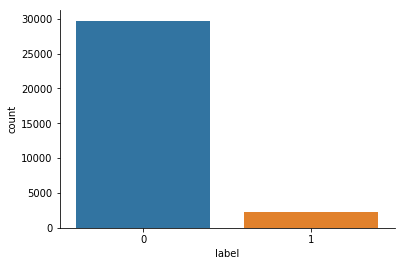

In [297]:
sns.countplot(train_original['label'])
sns.despine()

#### Conclusion
- Words associated with negative and positive tweets tell us a lot about the public sentiment at that time. 
- For example, a lot of negative tweets have the words: `trump`, `hispanic` etc. This was surprising to me because it really showed how racism and politics are play a role together and also how there are common themes such as `love`, `family` etc
##### Exploring Further: 
- I want to explore how this links with overal sentiment and events. For example I want to see how we can generate this type of graph. 
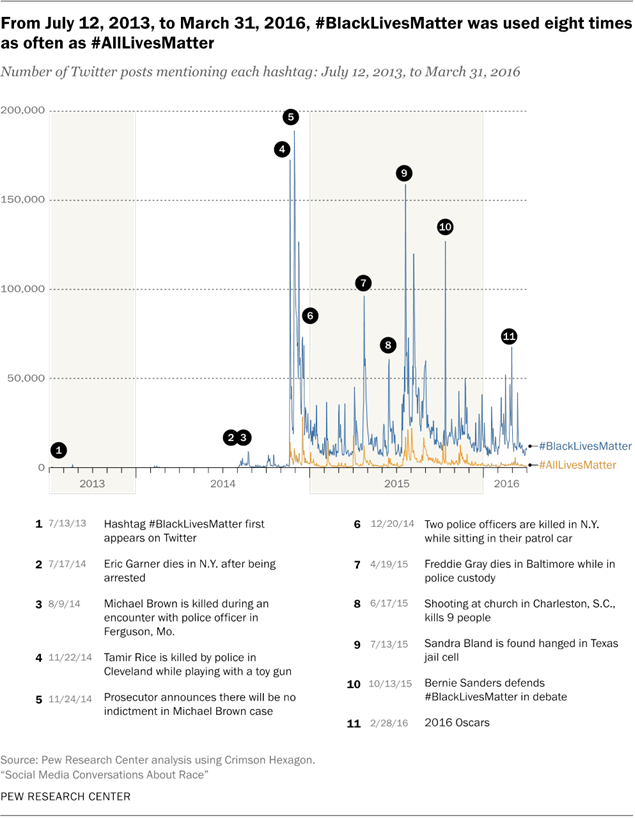

#### Citations:
- Part 1: “Social Media Sentiment Analysis using Machine Learning : Part — I” by Deepak Das https://link.medium.com/dvr0UN1Zr6

- Part 2: “Social Media Sentiment Analysis using Machine Learning : Part — II” by Deepak Das https://link.medium.com/fhTGul4Zr6

- The hashtag #BlackLivesMatter emerges: Social activism on Twitter
https://www.pewresearch.org/internet/2016/08/15/the-hashtag-blacklivesmatter-emerges-social-activism-on-twitter/

- Tweets Dataset
https://github.com/dD2405/Twitter_Sentiment_Analysis